/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:08:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Model Evaluation Results ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
            XGBoost  0.894507   0.896122 0.892414  0.894264 0.975654    0.879728
     MLP Neural Net  0.893818   0.898187 0.888276  0.893204 0.972728    0.535841
Logistic Regression  0.891979   0.888029 0.897011  0.892498 0.966459    0.881652
                SVM  0.892439   0.892775 0.891954  0.892364 0.970284    0.534761
           AdaBoost  0.888761   0.865543 0.920460  0.892157 0.970360    0.882802
  Gradient Boosting  0.893358   0.902588 0.881839  0.892093 0.977006    0.879259
      Random Forest  0.889910   0.897376 0.880460  0.888837 0.973886    0.872855
      Decision Tree  0.884624   0.887807 0.880460  0.884118 0.884623    0.878249
                KNN  0.880947   0.887693 0.872184  0.879870 0.959747    0.873023
        Naive Bayes  0.804872   0.955983 0.639080  0.766051 0.947641    0.806001

Results exported to: model_performance_results.xlsx
Classification reports

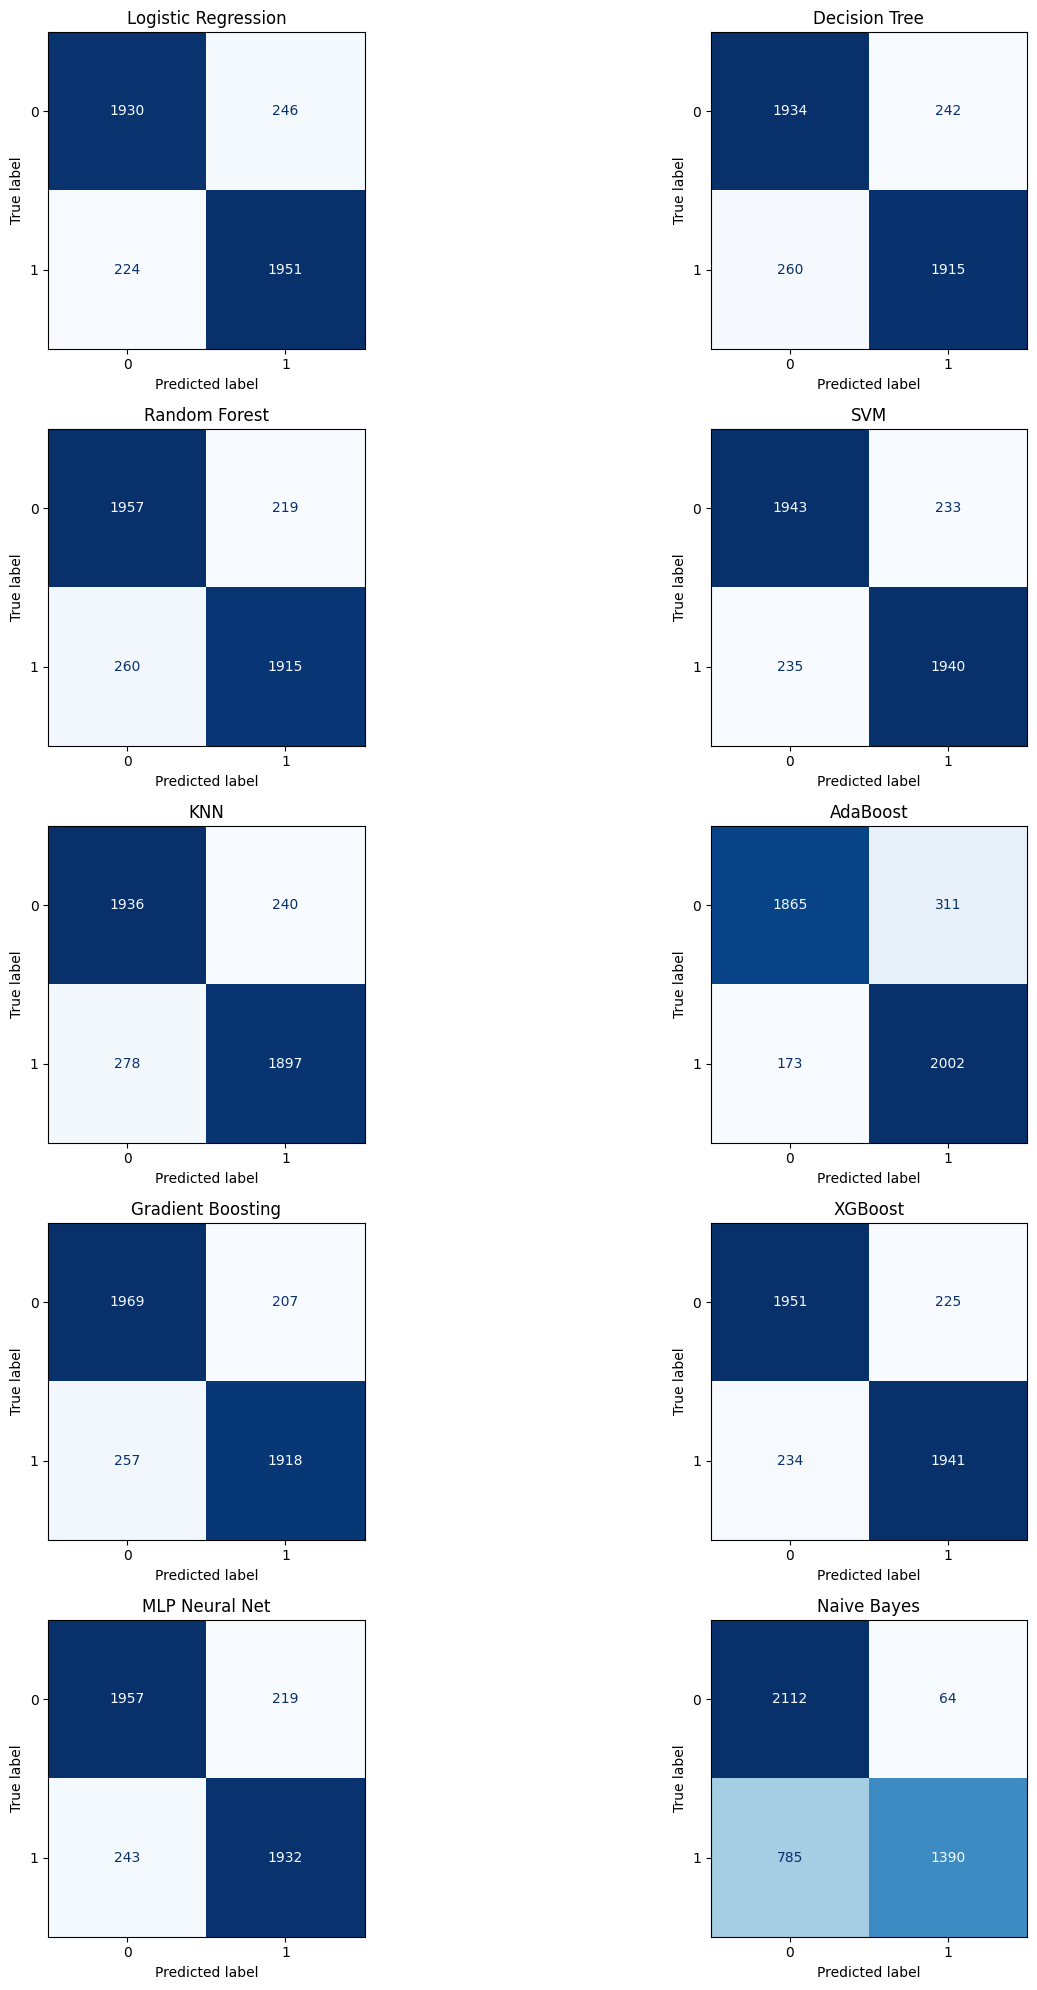

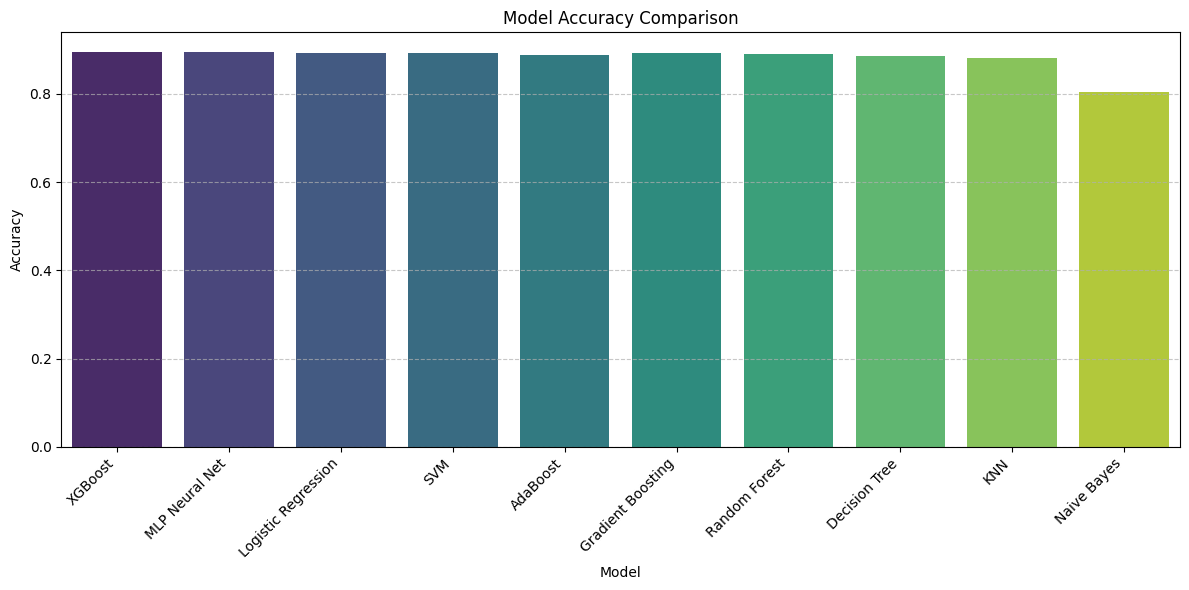

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_excel("modbus_dataset.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "MLP Neural Net": MLPClassifier(max_iter=500),
    "Naive Bayes": GaussianNB()
}

# Evaluate models
results = []
classification_reports = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Cross-validation F1
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC AUC": auc,
        "F1 CV Mean": f1_cv
    })

    # Store classification report
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)

# Save results to Excel
results_df.to_excel("model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(5, 2, figsize=(16, 20))
axs = axs.flatten()

for i, (name, model) in enumerate(models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)

plt.tight_layout()
plt.savefig("confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nResults exported to: model_performance_results.xlsx")
print("Classification reports saved to: classification_reports.txt")
print("Confusion matrices saved to: confusion_matrices.png")
print("Accuracy bar plot saved to: model_accuracy_barplot.png")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_excel("modbus_dataset.xlsx")

# Convert label to integer and drop noisy columns
df['Label'] = df['Label'].astype(int)
df.drop(columns=['Is_Modbus', 'src_ip', 'dst_ip', 'Reference Number', 'Word Count'], inplace=True, errors='ignore')

# Replace noisy values (-1) with NaN and drop rows with NaNs
df.replace(-1, np.nan, inplace=True)
df.dropna(inplace=True)

# Features and target
X = df.drop(columns=['Label'])
y = df['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Define ML models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Evaluate models
best_model = None
best_f1 = 0.0

print("\n📊 Model Evaluation:\n")

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    print(f"\n🔍 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    if f1 > best_f1:
        best_f1 = f1
        best_model = name

print(f"\n🏆 Best Model for MITM Attack Detection: {best_model} (Weighted F1-score = {best_f1:.4f})")



📊 Model Evaluation:


🔍 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      3195
           1       0.72      0.81      0.77      1539

    accuracy                           0.84      4734
   macro avg       0.81      0.83      0.82      4734
weighted avg       0.85      0.84      0.84      4734


🔍 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3195
           1       0.72      0.87      0.79      1539

    accuracy                           0.85      4734
   macro avg       0.83      0.85      0.84      4734
weighted avg       0.86      0.85      0.85      4734


🔍 SVM Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      3195
           1       0.69      0.94      0.79      1539

    accuracy                           0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:04:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW


=== Model Evaluation Results ===
            Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     XGBoost (GA)  0.896346   0.905075 0.885517  0.895189 0.975819    0.881516
XGBoost (Default)  0.891979   0.890518 0.893793  0.892152 0.975168    0.886922

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']
Results exported to: ga_model_performance_results.xlsx
Classification reports saved to: ga_classification_reports.txt
Confusion matrices saved to: ga_confusion_matrices.png
Accuracy bar plot saved to: model_accuracy_barplot.png


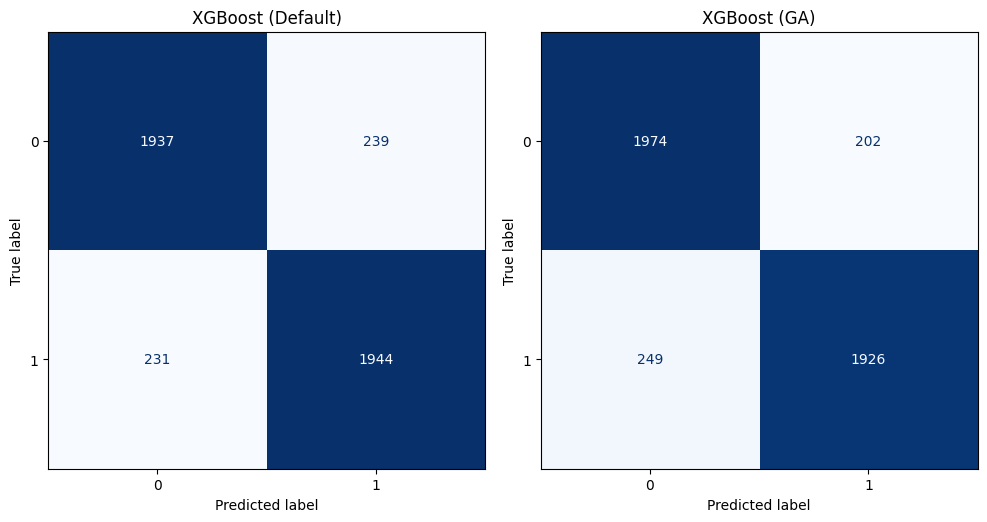

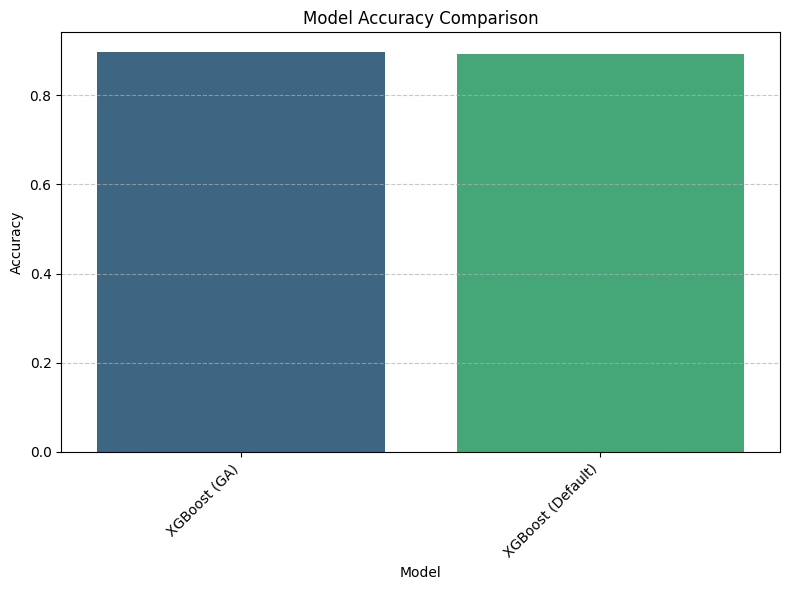

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median())

# Feature selection with RFE
base_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for XGBoost
model_params = {
    "XGBoost": {
        "model": XGBClassifier,
        "params": {
            "n_estimators": (50, 200),
            "max_depth": (3, 10),
            "learning_rate": (0.01, 0.3),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Ensure proper parameters
    if model_name == "XGBoost":
        param_dict["eval_metric"] = "logloss"
        param_dict["use_label_encoder"] = False
        # Explicitly enforce subsample constraint
        if "subsample" in param_dict:
            param_dict["subsample"] = max(0.5, min(1.0, param_dict["subsample"]))
        # Explicitly enforce colsample_bytree constraint
        if "colsample_bytree" in param_dict:
             param_dict["colsample_bytree"] = max(0.0, min(1.0, param_dict["colsample_bytree"]))
        # Explicitly enforce learning_rate constraint
        if "learning_rate" in param_dict:
            param_dict["learning_rate"] = max(0.0, param_dict["learning_rate"])


    # Train and evaluate model
    model = model_class(**param_dict)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], (int, float)):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            if isinstance(bounds[0], int):
                individual[idx] = int(round(individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default XGBoost for comparison
default_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "XGBoost (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["XGBoost (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["XGBoost (Default)"] = default_model

# GA-optimized XGBoost
model_name = "XGBoost"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(best_ind[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = best_ind[idx]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
            idx += 1
param_dict["eval_metric"] = "logloss"
param_dict["use_label_encoder"] = False
# Explicitly enforce subsample constraint again for the final model
if "subsample" in param_dict:
    param_dict["subsample"] = max(0.5, min(1.0, param_dict["subsample"]))
# Explicitly enforce colsample_bytree constraint again for the final model
if "colsample_bytree" in param_dict:
    param_dict["colsample_bytree"] = max(0.0, min(1.0, param_dict["colsample_bytree"]))
# Explicitly enforce learning_rate constraint again for the final model
if "learning_rate" in param_dict:
    param_dict["learning_rate"] = max(0.0, param_dict["learning_rate"])


# Train best model
model = XGBClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "XGBoost (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["XGBoost (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["XGBoost (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("ga_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("ga_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("ga_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("ga_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: ga_model_performance_results.xlsx")
print("Classification reports saved to: ga_classification_reports.txt")
print("Confusion matrices saved to: ga_confusion_matrices.png")
print("Accuracy bar plot saved to: model_accuracy_barplot.png")

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

Grid Search Best Parameters: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 150, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


=== Model Evaluation Results ===
            Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     XGBoost (GA)  0.897265   0.911037 0.880460  0.895487 0.976084    0.878683
XGBoost (Default)  0.891060   0.888534 0.894253  0.891384 0.974208    0.883792
   XGBoost (Grid)  0.888991   0.887008 0.891494  0.889246 0.974895    0.882481

Selected features: ['protocol_encoded', 'Function Code', 'Time', 'Length', 'Unit Identifier', 'Transaction Identifier']
Results exported to: ga_model_performance_results.xlsx
Classification reports saved to: ga_classification_reports.txt
Confusion matrices saved to: ga_confusion_matrices.png
Accuracy bar plot saved to: ga_model_accuracy_barplot.png


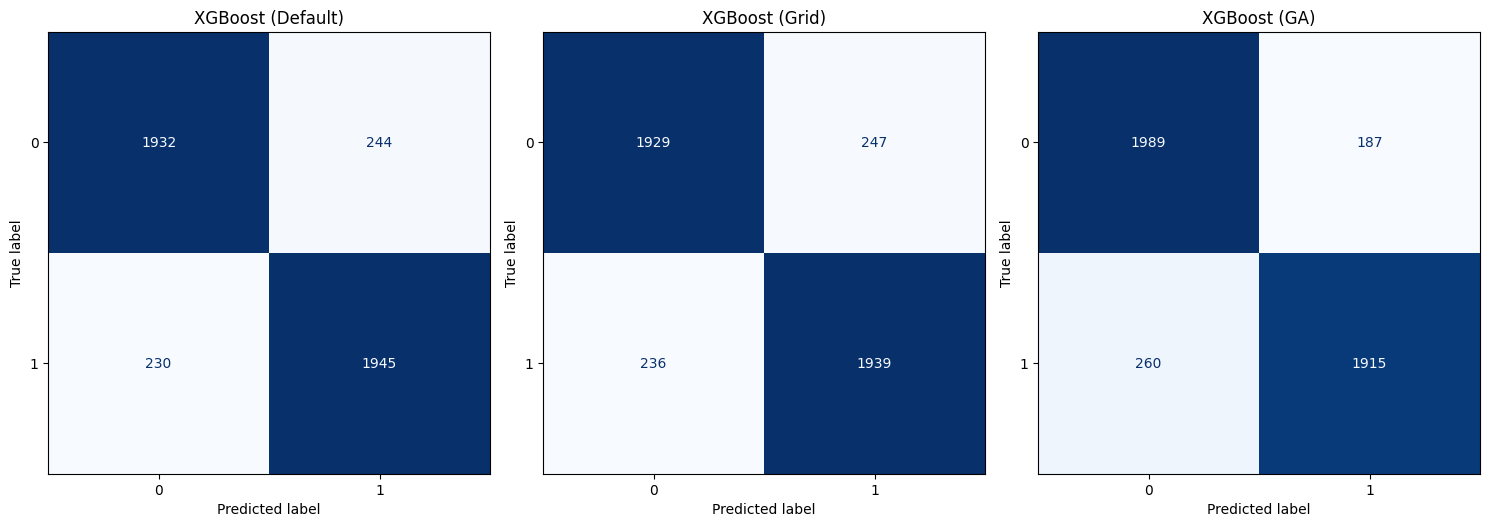

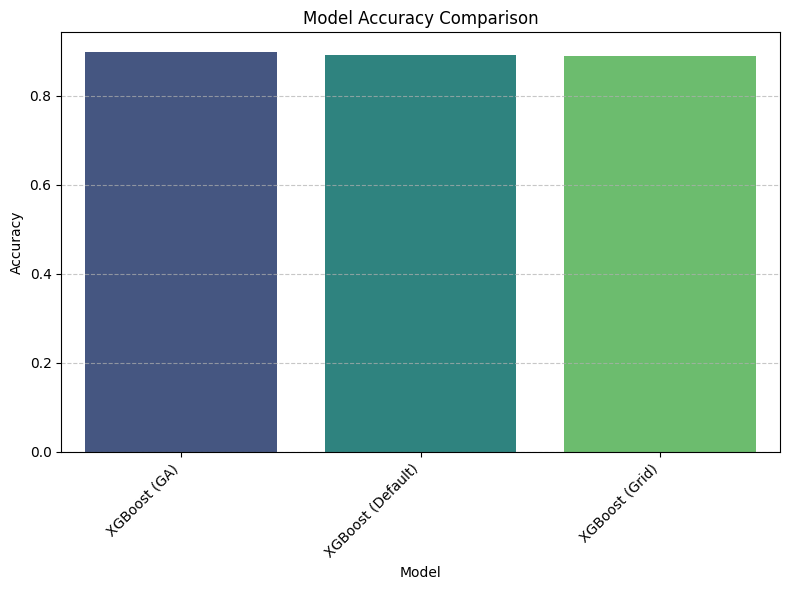

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Manual feature selection to focus on high-signal features
selected_features = ["protocol_encoded", "Function Code", "Time", "Length",
                    "Unit Identifier", "Transaction Identifier"] # Removed 'src_port', 'dst_port'
X = X[selected_features]

# Handle categorical features and noise
for col in X.columns:
    if X[col].dtype == 'object' or X[col].eq(-1).any():
        X[col] = X[col].replace(-1, np.nan)
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
        else:
            X[col] = X[col].fillna(X[col].median())

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for XGBoost
model_params = {
    "XGBoost": {
        "model": XGBClassifier,
        "params": {
            "n_estimators": (50, 150),  # Narrower range
            "max_depth": (4, 8),        # Targeted for structured data
            "learning_rate": (0.05, 0.15),  # Focused range
            "subsample": (0.7, 1.0),
            "colsample_bytree": (0.7, 1.0)
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Ensure proper parameters
    param_dict["eval_metric"] = "logloss"
    param_dict["use_label_encoder"] = False

    # Explicitly enforce constraints
    if model_name == "XGBoost":
        if "subsample" in param_dict:
            param_dict["subsample"] = max(0.0, min(1.0, param_dict["subsample"]))
        if "colsample_bytree" in param_dict:
             param_dict["colsample_bytree"] = max(0.0, min(1.0, param_dict["colsample_bytree"]))
        if "learning_rate" in param_dict:
            param_dict["learning_rate"] = max(0.0, param_dict["learning_rate"])


    # Train and evaluate model
    model = model_class(**param_dict)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default XGBoost
default_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "XGBoost (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["XGBoost (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["XGBoost (Default)"] = default_model

# Grid Search XGBoost
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.15],
    "subsample": [0.7, 1.0]
}
grid_model = GridSearchCV(
    XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_model.fit(X_train, y_train)
y_pred_grid = grid_model.predict(X_test)
y_prob_grid = grid_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "XGBoost (Grid)",
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision": precision_score(y_test, y_pred_grid),
    "Recall": recall_score(y_test, y_pred_grid),
    "F1-Score": f1_score(y_test, y_pred_grid),
    "ROC AUC": roc_auc_score(y_test, y_prob_grid),
    "F1 CV Mean": cross_val_score(grid_model.best_estimator_, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["XGBoost (Grid)"] = classification_report(y_test, y_pred_grid, output_dict=True)
best_models["XGBoost (Grid)"] = grid_model.best_estimator_
print(f"Grid Search Best Parameters: {grid_model.best_params_}")

# GA-optimized XGBoost
model_name = "XGBoost"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
hof = tools.HallOfFame(1)  # Preserve best individual
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.3,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=hof)

# Get best individual
best_ind = hof[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], int):
        param_dict[param] = int(round(best_ind[idx]))
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
        param_dict[param] = best_ind[idx]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
param_dict["eval_metric"] = "logloss"
param_dict["use_label_encoder"] = False
# Explicitly enforce subsample constraint again for the final model
if "subsample" in param_dict:
    param_dict["subsample"] = max(0.0, min(1.0, param_dict["subsample"]))
# Explicitly enforce colsample_bytree constraint again for the final model
if "colsample_bytree" in param_dict:
    param_dict["colsample_bytree"] = max(0.0, min(1.0, param_dict["colsample_bytree"]))
# Explicitly enforce learning_rate constraint again for the final model
if "learning_rate" in param_dict:
    param_dict["learning_rate"] = max(0.0, param_dict["learning_rate"])


# Train best model
model = XGBClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "XGBoost (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["XGBoost (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["XGBoost (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("ga_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("ga_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("ga_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("ga_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: ga_model_performance_results.xlsx")
print("Classification reports saved to: ga_classification_reports.txt")
print("Confusion matrices saved to: ga_confusion_matrices.png")
print("Accuracy bar plot saved to: ga_model_accuracy_barplot.png")

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']


<ipython-input-4-8a001e37071f>:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")



=== Model Evaluation Results ===
                 Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     RandomForest (GA)  0.894047   0.878534 0.914483  0.896148 0.975250    0.883071
RandomForest (Default)  0.888531   0.894491 0.880920  0.887653 0.973008    0.844403

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']
Results exported to: rf_model_performance_results.xlsx
Classification reports saved to: rf_classification_reports.txt
Confusion matrices saved to: rf_confusion_matrices.png
Accuracy bar plot saved to: rf_model_accuracy_barplot.png


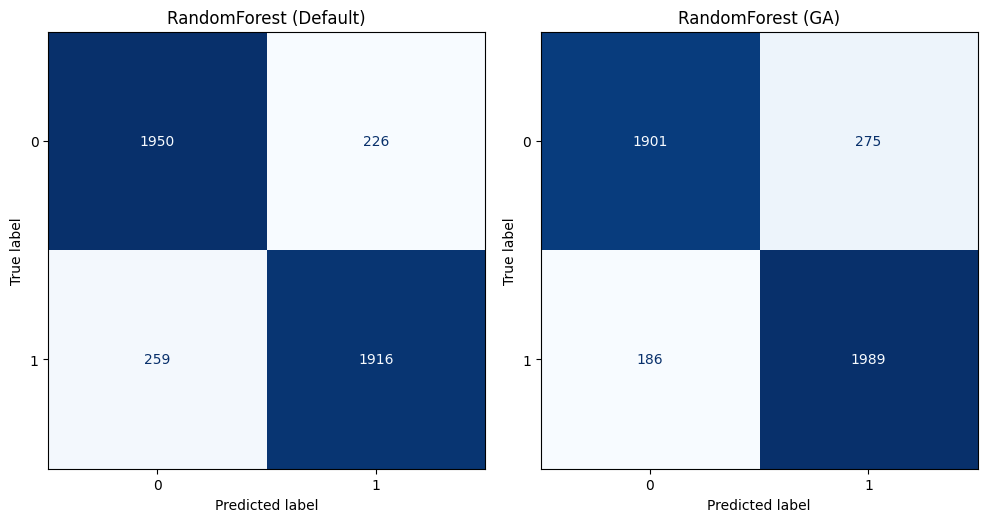

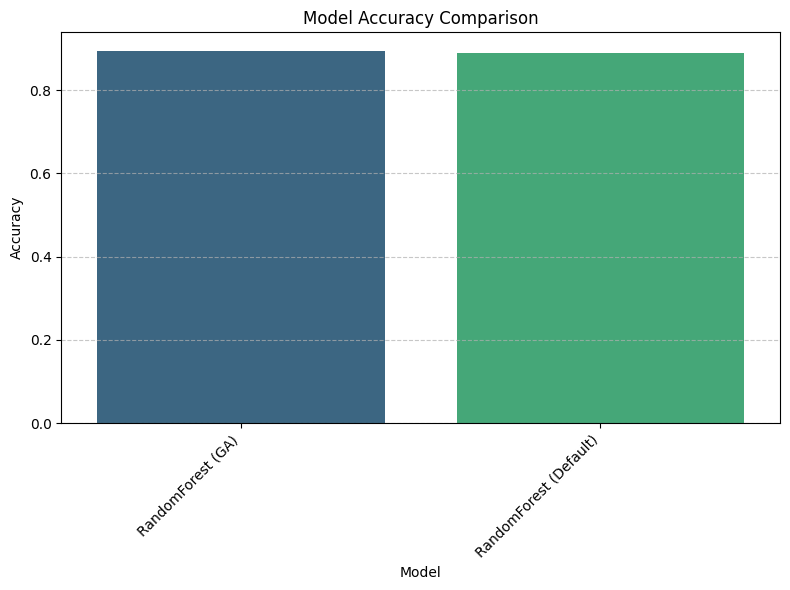

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using Random Forest
base_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for Random Forest
model_params = {
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators": (50, 200),
            "max_depth": (10, 30),
            "min_samples_split": (2, 10),
            "min_samples_leaf": (1, 4),
            "max_features": ("sqrt", "log2", None)
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Train and evaluate model
    model = model_class(**param_dict, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], (int, float)):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            if isinstance(bounds[0], int):
                individual[idx] = int(round(individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default Random Forest for comparison
default_model = RandomForestClassifier(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "RandomForest (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["RandomForest (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["RandomForest (Default)"] = default_model

# GA-optimized Random Forest
model_name = "RandomForest"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], int):
        param_dict[param] = int(round(best_ind[idx]))
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
        param_dict[param] = best_ind[idx]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
param_dict["random_state"] = 42

# Train best model
model = RandomForestClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "RandomForest (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["RandomForest (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["RandomForest (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("rf_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("rf_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("rf_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("rf_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: rf_model_performance_results.xlsx")
print("Classification reports saved to: rf_classification_reports.txt")
print("Confusion matrices saved to: rf_confusion_matrices.png")
print("Accuracy bar plot saved to: rf_model_accuracy_barplot.png")

In [ ]:
%pip install deap

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Unit Identifier', 'Function Code']


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: Convergence


=== Model Evaluation Results ===
                       Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     LogisticRegression (GA)  0.880028   0.843088 0.933793  0.886126 0.931275    0.879145
LogisticRegression (Default)  0.879798   0.842739 0.933793  0.885932 0.931300    0.877902

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Unit Identifier', 'Function Code']
Results exported to: lr_model_performance_results.xlsx
Classification reports saved to: lr_classification_reports.txt
Confusion matrices saved to: lr_confusion_matrices.png
Accuracy bar plot saved to: lr_model_accuracy_barplot.png


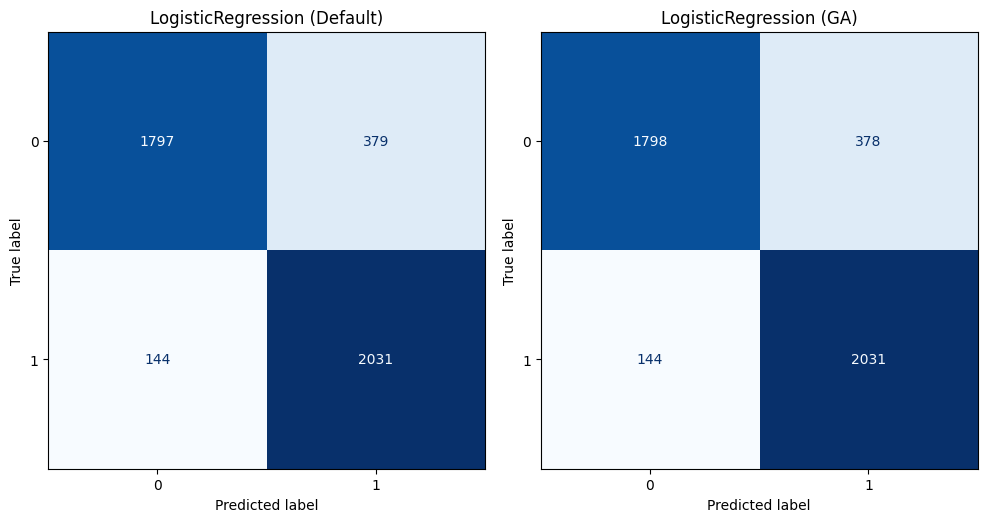

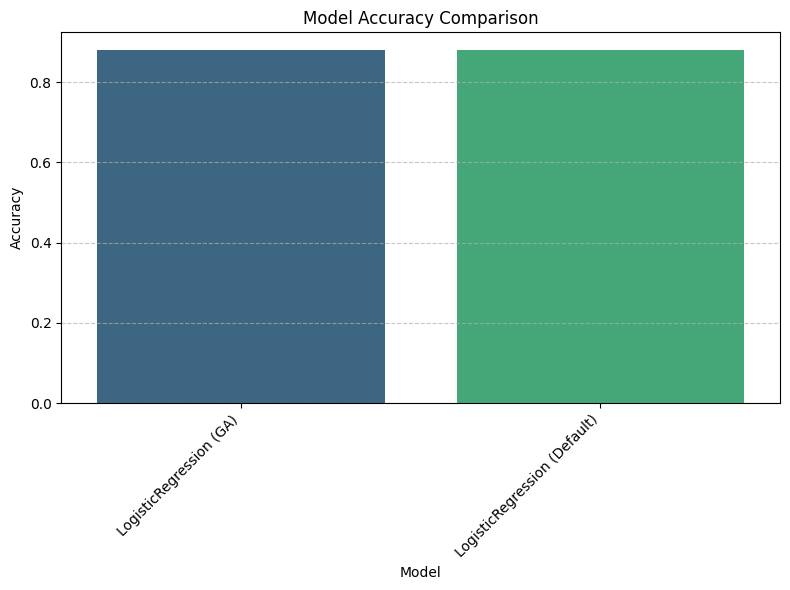

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using Logistic Regression
base_model = LogisticRegression(random_state=42, solver='liblinear')
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for Logistic Regression
model_params = {
    "LogisticRegression": {
        "model": LogisticRegression,
        "params": {
            "C": (0.01, 10.0),  # Regularization strength (inverse of regularization)
            "penalty": ("l1", "l2"),  # Regularization type
            "solver": ("liblinear",)  # Solver (liblinear supports both l1 and l2)
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Train and evaluate model
    model = model_class(**param_dict, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            individual.append(random.randint(0, len(bounds) - 1))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default Logistic Regression for comparison
default_model = LogisticRegression(random_state=42, solver='liblinear')
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "LogisticRegression (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["LogisticRegression (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["LogisticRegression (Default)"] = default_model

# GA-optimized Logistic Regression
model_name = "LogisticRegression"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], float):
        param_dict[param] = best_ind[idx]
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
param_dict["random_state"] = 42

# Train best model
model = LogisticRegression(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "LogisticRegression (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["LogisticRegression (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["LogisticRegression (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("lr_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("lr_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("lr_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("lr_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: lr_model_performance_results.xlsx")
print("Classification reports saved to: lr_classification_reports.txt")
print("Confusion matrices saved to: lr_confusion_matrices.png")
print("Accuracy bar plot saved to: lr_model_accuracy_barplot.png")

In [ ]:
%pip install deap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using SVM with linear kernel
base_model = SVC(kernel='linear', random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling (crucial for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for SVM
model_params = {
    "SVM": {
        "model": SVC,
        "params": {
            "C": (0.1, 10.0),  # Regularization parameter
            "kernel": ("linear", "rbf"),  # Kernel type
            "gamma": (0.001, 1.0)  # Kernel coefficient (used only for rbf kernel)
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Ensure gamma is only used with rbf kernel
    if param_dict["kernel"] != "rbf":
        param_dict.pop("gamma", None)

    # Train and evaluate model
    model = model_class(**param_dict, probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            individual.append(random.randint(0, len(bounds) - 1))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default SVM for comparison
default_model = SVC(kernel='rbf', probability=True, random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "SVM (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["SVM (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["SVM (Default)"] = default_model

# GA-optimized SVM
model_name = "SVM"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], float):
        param_dict[param] = best_ind[idx]
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
# Ensure gamma is only used with rbf kernel
if param_dict["kernel"] != "rbf":
    param_dict.pop("gamma", None)
param_dict["probability"] = True
param_dict["random_state"] = 42

# Train best model
model = SVC(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "SVM (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["SVM (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["SVM (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("svm_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("svm_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("svm_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("svm_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: svm_model_performance_results.xlsx")
print("Classification reports saved to: svm_classification_reports.txt")
print("Confusion matrices saved to: svm_confusion_matrices.png")
print("Accuracy bar plot saved to: svm_model_accuracy_barplot.png")

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']


<ipython-input-1-9bd452dce7a6>:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")



=== Model Evaluation Results ===
                 Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     DecisionTree (GA)  0.897954   0.906529 0.887356  0.896840 0.945888    0.875819
DecisionTree (Default)  0.887612   0.889556 0.885057  0.887301 0.887611    0.880912

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']
Results exported to: dt_model_performance_results.xlsx
Classification reports saved to: dt_classification_reports.txt
Confusion matrices saved to: dt_confusion_matrices.png
Accuracy bar plot saved to: dt_model_accuracy_barplot.png


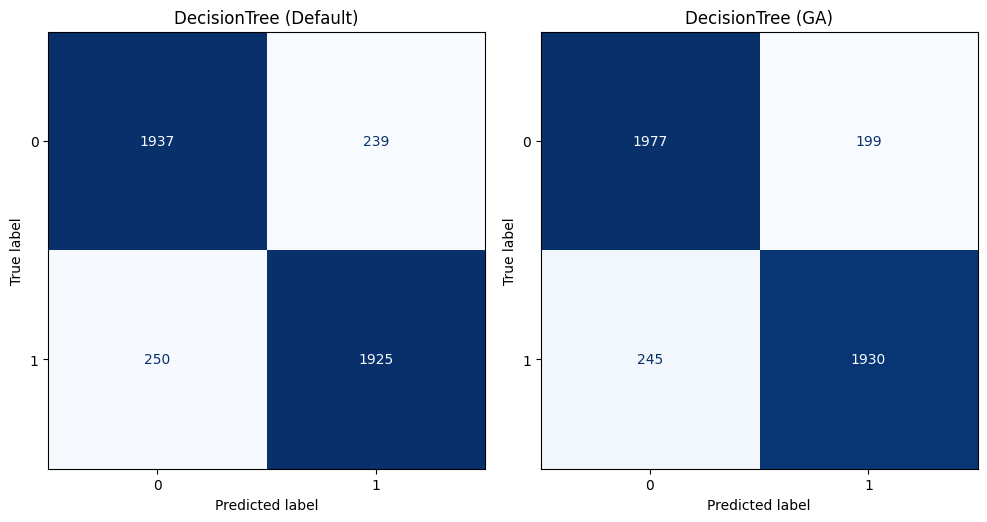

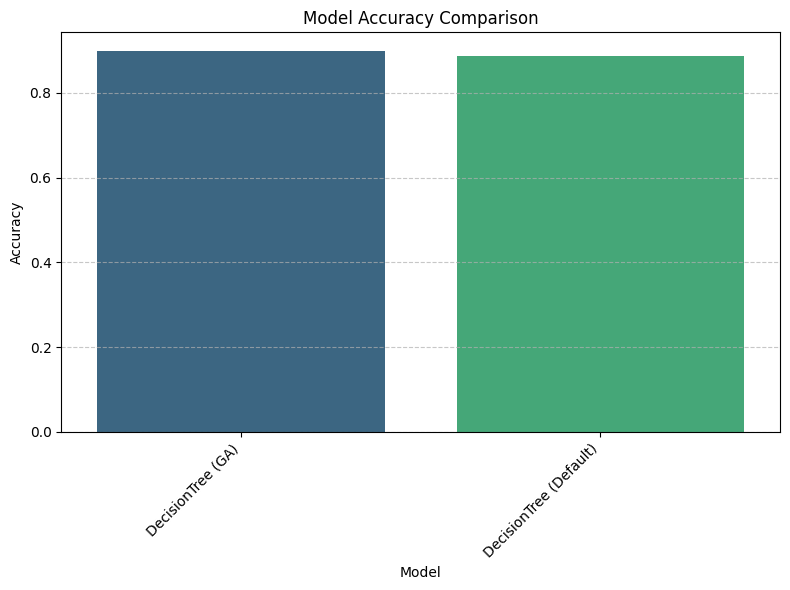

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using Decision Tree
base_model = DecisionTreeClassifier(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling (optional for Decision Tree, but included for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for Decision Tree
model_params = {
    "DecisionTree": {
        "model": DecisionTreeClassifier,
        "params": {
            "max_depth": (3, 20),  # Maximum depth of the tree
            "min_samples_split": (2, 10),  # Minimum samples required to split
            "min_samples_leaf": (1, 5),  # Minimum samples required at a leaf
            "criterion": ("gini", "entropy")  # Split criterion
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Train and evaluate model
    model = model_class(**param_dict, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            individual.append(random.randint(0, len(bounds) - 1))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            individual[idx] = int(round(individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default Decision Tree for comparison
default_model = DecisionTreeClassifier(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "DecisionTree (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["DecisionTree (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["DecisionTree (Default)"] = default_model

# GA-optimized Decision Tree
model_name = "DecisionTree"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], int):
        param_dict[param] = int(round(best_ind[idx]))
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
param_dict["random_state"] = 42

# Train best model
model = DecisionTreeClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "DecisionTree (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["DecisionTree (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["DecisionTree (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("dt_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("dt_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("dt_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("dt_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: dt_model_performance_results.xlsx")
print("Classification reports saved to: dt_classification_reports.txt")
print("Confusion matrices saved to: dt_confusion_matrices.png")
print("Accuracy bar plot saved to: dt_model_accuracy_barplot.png")

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
<ipython-input-4-614c02d035dd>:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")



=== Model Evaluation Results ===
        Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     kNN (GA)  0.887382   0.878652 0.898851  0.888636 0.965508    0.876305
kNN (Default)  0.874282   0.871350 0.878161  0.874742 0.956695    0.875198

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']
Results exported to: knn_model_performance_results.xlsx
Classification reports saved to: knn_classification_reports.txt
Confusion matrices saved to: knn_confusion_matrices.png
Accuracy bar plot saved to: knn_model_accuracy_barplot.png


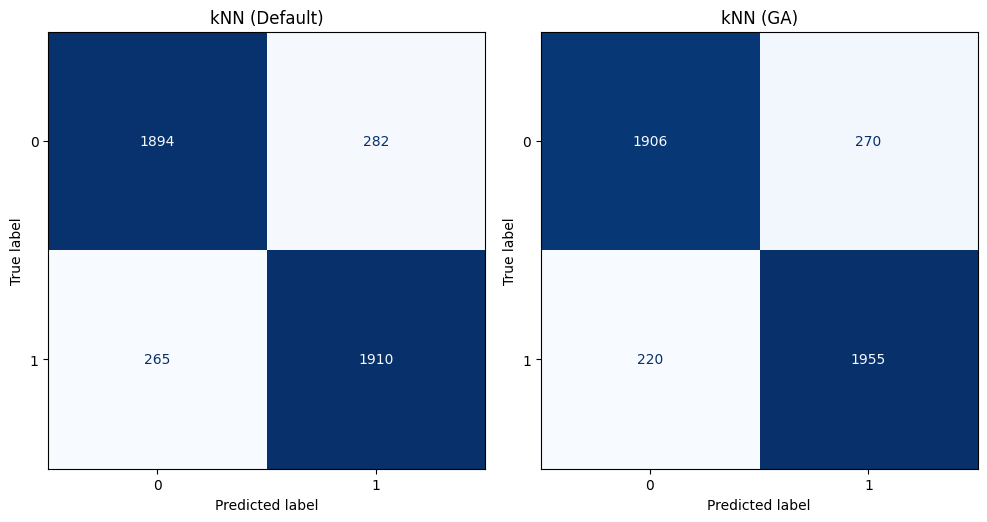

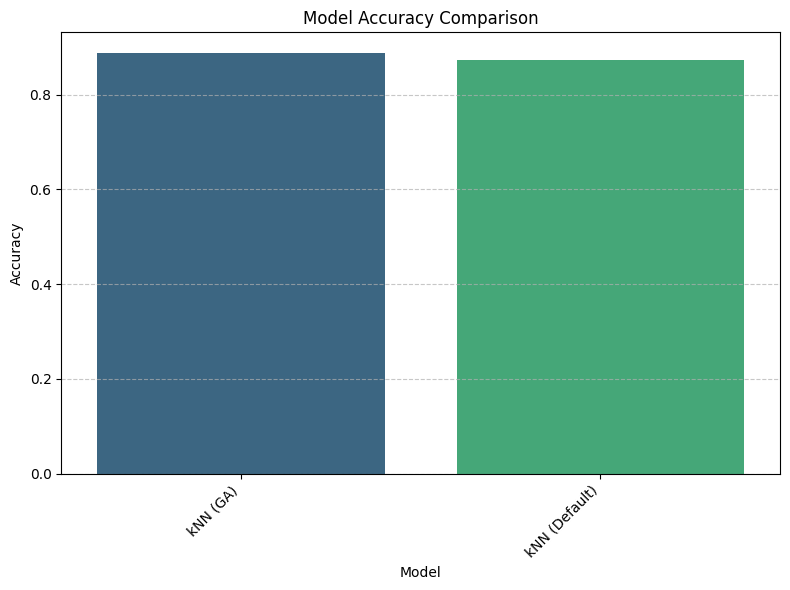

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using RandomForestClassifier
base_model = RandomForestClassifier(random_state=42) # Use RandomForestClassifier for RFE
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling (crucial for kNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for kNN
model_params = {
    "kNN": {
        "model": KNeighborsClassifier,
        "params": {
            "n_neighbors": (3, 15),  # Number of neighbors
            "weights": ("uniform", "distance"),  # Weight function
            "metric": ("euclidean", "manhattan")  # Distance metric
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Train and evaluate model
    model = model_class(**param_dict)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
            individual.append(random.randint(0, len(bounds) - 1))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            individual[idx] = int(round(individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default kNN for comparison
default_model = KNeighborsClassifier()
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "kNN (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["kNN (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["kNN (Default)"] = default_model

# GA-optimized kNN
model_name = "kNN"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], int):
        param_dict[param] = int(round(best_ind[idx]))
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], str):
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1

# Train best model
model = KNeighborsClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "kNN (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["kNN (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["kNN (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("knn_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("knn_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("knn_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("knn_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: knn_model_performance_results.xlsx")
print("Classification reports saved to: knn_classification_reports.txt")
print("Confusion matrices saved to: knn_confusion_matrices.png")
print("Accuracy bar plot saved to: knn_model_accuracy_barplot.png")

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
<ipython-input-2-2039166554e2>:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")



=== Model Evaluation Results ===
                     Model  Accuracy  Precision   Recall  F1-Score  ROC AUC  F1 CV Mean
     GradientBoosting (GA)  0.898644   0.884309 0.917241  0.900474 0.977331    0.882584
GradientBoosting (Default)  0.894277   0.893891 0.894713  0.894301 0.976243    0.884417

Selected features: ['Time', 'src_ip', 'dst_ip', 'protocol_encoded', 'Transaction Identifier', 'Length', 'Function Code', 'Word Count']
Results exported to: gb_model_performance_results.xlsx
Classification reports saved to: gb_classification_reports.txt
Confusion matrices saved to: gb_confusion_matrices.png
Accuracy bar plot saved to: gb_model_accuracy_barplot.png


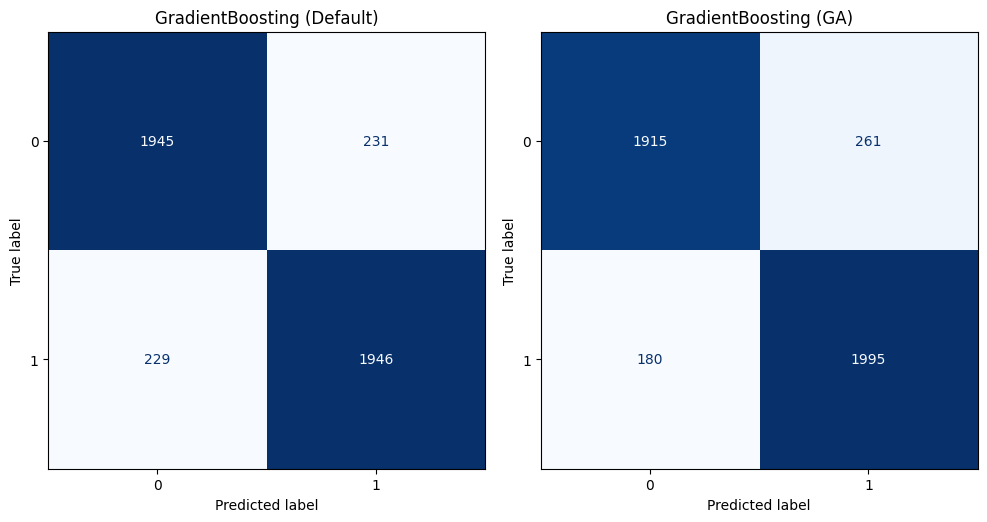

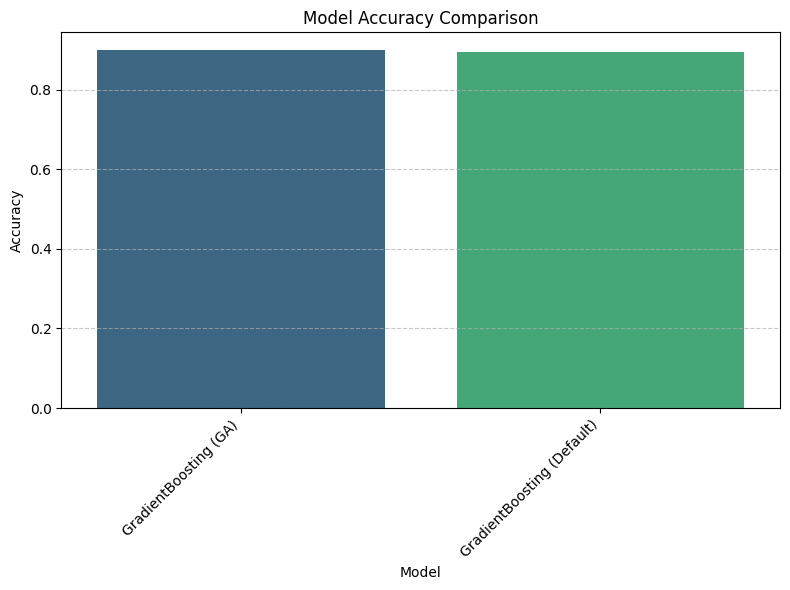

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms
from sklearn.feature_selection import RFE
import random
from joblib import Parallel, delayed

# Load the dataset
df = pd.read_excel("modbus_dataset_11.xlsx", engine='openpyxl')

# Drop 'Is_Modbus' as it was not used in the original feature set
X = df.drop(columns=["Label", "Is_Modbus"])
y = df["Label"].astype(int)

# Handle noisy values (e.g., -1) by replacing with median
X = X.replace(-1, np.nan).fillna(X.median(numeric_only=True))

# Feature selection with RFE using Gradient Boosting
base_model = GradientBoostingClassifier(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_].tolist()
print(f"Selected features: {selected_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling (optional for Gradient Boosting, but included for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define model and hyperparameter space for Gradient Boosting
model_params = {
    "GradientBoosting": {
        "model": GradientBoostingClassifier,
        "params": {
            "n_estimators": (50, 200),  # Number of boosting stages
            "learning_rate": (0.01, 0.3),  # Learning rate
            "max_depth": (3, 10),  # Maximum depth of trees
            "subsample": (0.5, 1.0)  # Fraction of samples for fitting trees
        }
    }
}

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate_individual(individual, model_name, X_train, y_train, X_test, y_test):
    params = model_params[model_name]["params"]
    model_class = model_params[model_name]["model"]

    # Map individual to parameters
    param_dict = {}
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            param_dict[param] = int(round(individual[idx]))
            idx += 1
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            param_dict[param] = individual[idx]
            idx += 1
        else:
            param_dict[param] = bounds[int(round(individual[idx])) % len(bounds)]
            idx += 1

    # Ensure subsample and learning_rate are within valid range
    if model_name == "GradientBoosting":
        if "subsample" in param_dict:
            # Ensure subsample is within the valid range (0.0, 1.0]
            param_dict["subsample"] = max(0.0001, min(1.0, param_dict["subsample"])) # Use a small value instead of 0
        if "learning_rate" in param_dict:
            # Ensure learning_rate is non-negative
            param_dict["learning_rate"] = max(0.0, param_dict["learning_rate"])


    # Train and evaluate model
    model = model_class(**param_dict, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred),

def init_individual(model_name):
    params = model_params[model_name]["params"]
    individual = []
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], int):
            individual.append(random.randint(bounds[0], bounds[1]))
        elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
            individual.append(random.uniform(bounds[0], bounds[1]))
        else:
            individual.append(random.randint(0, len(bounds) - 1))
    return creator.Individual(individual)

def constraint(individual, model_name):
    params = model_params[model_name]["params"]
    idx = 0
    for param, bounds in params.items():
        if isinstance(bounds, tuple) and isinstance(bounds[0], (int, float)):
            individual[idx] = max(bounds[0], min(bounds[1], individual[idx]))
            if isinstance(bounds[0], int):
                individual[idx] = int(round(individual[idx]))
            idx += 1
        else:
            individual[idx] = int(round(individual[idx])) % len(bounds)
            idx += 1
    return individual

# Evaluate models
results = []
classification_reports = {}
best_models = {}

# Default Gradient Boosting for comparison
default_model = GradientBoostingClassifier(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
y_prob_default = default_model.predict_proba(X_test)[:, 1]
results.append({
    "Model": "GradientBoosting (Default)",
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-Score": f1_score(y_test, y_pred_default),
    "ROC AUC": roc_auc_score(y_test, y_prob_default),
    "F1 CV Mean": cross_val_score(default_model, X_bal, y_bal, cv=5, scoring='f1').mean()
})
classification_reports["GradientBoosting (Default)"] = classification_report(y_test, y_pred_default, output_dict=True)
best_models["GradientBoosting (Default)"] = default_model

# GA-optimized Gradient Boosting
model_name = "GradientBoosting"
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, model_name)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, model_name=model_name,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA with parallel evaluation
population = toolbox.population(n=20)
n_generations = 10
pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                               ngen=n_generations, verbose=False,
                               stats=None, halloffame=None)

# Get best individual
best_ind = tools.selBest(population, k=1)[0]
best_acc = best_ind.fitness.values[0]

# Reconstruct best model
param_dict = {}
idx = 0
for param, bounds in model_params[model_name]["params"].items():
    if isinstance(bounds, tuple) and isinstance(bounds[0], int):
        param_dict[param] = int(round(best_ind[idx]))
        idx += 1
    elif isinstance(bounds, tuple) and isinstance(bounds[0], float):
        param_dict[param] = best_ind[idx]
        idx += 1
    else:
        param_dict[param] = bounds[int(round(best_ind[idx])) % len(bounds)]
        idx += 1
# Ensure subsample is within valid range
if "subsample" in param_dict:
    param_dict["subsample"] = max(0.5, min(1.0, param_dict["subsample"]))
param_dict["random_state"] = 42

# Train best model
model = GradientBoostingClassifier(**param_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='f1').mean()

# Store results
results.append({
    "Model": "GradientBoosting (GA)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1,
    "ROC AUC": auc,
    "F1 CV Mean": f1_cv
})
classification_reports["GradientBoosting (GA)"] = classification_report(y_test, y_pred, output_dict=True)
best_models["GradientBoosting (GA)"] = model

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Save results to Excel
results_df.to_excel("gb_model_performance_results.xlsx", index=False)

# Save classification reports to a text file
with open("gb_classification_reports.txt", "w") as f:
    for name, report in classification_reports.items():
        f.write(f"\n=== Classification Report for {name} ===\n")
        f.write(pd.DataFrame(report).transpose().to_string())
        f.write("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for i, (name, model) in enumerate(best_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[i], colorbar=False
    )
    axs[i].set_title(name)
plt.tight_layout()
plt.savefig("gb_confusion_matrices.png")

# Plot bar plot for accuracies
plt.figure(figsize=(8, 6))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("gb_model_accuracy_barplot.png")

# Print results
print("\n=== Model Evaluation Results ===")
print(results_df.to_string(index=False))
print("\nSelected features:", selected_features)
print("Results exported to: gb_model_performance_results.xlsx")
print("Classification reports saved to: gb_classification_reports.txt")
print("Confusion matrices saved to: gb_confusion_matrices.png")
print("Accuracy bar plot saved to: gb_model_accuracy_barplot.png")